# Датасет по данным чятика

### Немного упоролся и решил поизучать чего понапописал народ в чатике devkz

Чтобы вытащить данные буду использовать библиотеку **telethon**

Для начала авторизуемся

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from telethon import TelegramClient

import pandas as pd
import numpy as np

from collections import Counter
from time import time

api_id = 149628
api_hash = '2cf6a449f6ce8c93589bfa19ac6be9c9'
phone_number = '+77025899060'

client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

# client.start()
assert client.connect()

if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())
    
chat_id = -1001075169847

Немного туповатый код, так как я для начала оценивал скорость скачивания сообщений. Оказалось порядка 20 сообщений в секунду. Негусто так то, учитывая, что бывают чатики, которые временами генерят контент с такой скоростью) Но нам хватит

In [2]:
from time import time
# last_messages_list = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 100000]
last_messages_list = [100000]
load_duration_dict = {}
for mess_count in last_messages_list:
    t_start = time()
    messages = client.get_message_history(chat_id, limit=mess_count)
    load_duration_dict[mess_count] = int(time() - t_start)
    print('{0} messages loads about {1} seconds'.format(len(messages), load_duration_dict[mess_count]))
    print('Last message is \'{}\''.format(messages[-1].message))
    print('date: ', messages[-1].date)
    print('=================================')

100000 messages loads about 1909 seconds
Last message is 'Мы спорим с тем чтобы везти микросеовисы и акка в боевой проект вместе со Скала'
date:  2017-09-07 13:54:34


### Вот так я могу обновлять свои данные, просто догружая все сообщения после последнего сохраненного

In [253]:
last_messages = client.get_message_history(chat_id, min_id=messages[0].id, limit=100500)
for mes in last_messages:
    print(mes.message)

я имею ввиду изучать оба на уровне хотя бы graduate level engineer
и то и то - это хобби)
Если я правильно понял :)
Одно другому никак не мешает ведь
есть олимпиадники асм или software engineers которые паралельно занимаются мл/дс? хотел проконсультироваться по сложности обучения в двух направлениях


### Немного почистил данные от вспомогательных сообщений, которые усложняют процессинг

In [4]:
import re

entry_messages = []
work_messages = []
# old_messages = messages
for mes in messages:
    try:
        mes.media
        work_messages.append(mes)
    except:
        entry_messages.append(mes)
messages = work_messages

### Чуть посмотрел на эти самые вспомогательные сообщения, посчитал кто как часто их генерит

In [5]:
from collections import Counter
users = []
users_ids = []
for mes in entry_messages:
    username = mes.sender.username
    users_ids.append(mes.from_id)
    if username:
        users.append(username)
    else:
        users.append(str(mes.sender.last_name) + '/' + str(mes.sender.first_name))
    
print(len(Counter(users).most_common()))
Counter(users).most_common(10)

352


[('pengovan', 18),
 ('codev0', 17),
 ('emilkip', 8),
 ('resurtm', 7),
 ('devkz_bot', 5),
 ('shadowsmind', 3),
 ('None/Arman', 3),
 ('madi_anarbek', 3),
 ('Diana_Knowles', 3),
 ('mitrio', 3)]

### Построил собственно датасет из самого необходимого

Также удалил всякую пунктуацию и построил себе айдишку пользователя из имени, фамилии, логина

In [176]:
corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in messages],
    'is_media': [not mes.media == None for mes in messages],
    'is_bot': [mes.sender.bot for mes in messages],
    'writer_id': [mes.from_id for mes in messages],
    'username': [mes.sender.username for mes in messages],
    'first_name': [mes.sender.first_name for mes in messages],
    'last_name': [mes.sender.last_name for mes in messages],
    'mes_date': [mes.date for mes in messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.fillna('', inplace=True)
corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'

corpus.to_csv('devkz.csv', index=None)

corpus.head(10)

<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence \W
<input>:21: DeprecationWarning: invalid escape sequence 

NameError: name 'messages' is not defined

In [2]:
corpus = pd.read_csv('devkz.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus.head()

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-09-07 13:54:34,мы спорим с тем чтобы везти микросеовисы и акк...,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
1,2017-09-07 13:54:38,хотя ты жавист,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
2,2017-09-07 13:54:44,и команда у тебя жависты,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
3,2017-09-07 13:55:07,так же интереснее да,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
4,2017-09-07 13:55:14,ну вот ты и сам получается скучный,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)


In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    stop_words.extend(stopwords.words('english'))
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('devkz_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to /home/sneddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sneddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-09-07 13:54:34,спорим везти микросеовисы акка боевой проект в...,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
1,2017-09-07 13:54:38,хотя жавист,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
2,2017-09-07 13:54:44,команда жависты,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
3,2017-09-07 13:55:07,интереснее,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
4,2017-09-07 13:55:14,получается скучный,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
5,2017-09-07 13:55:23,rust берёшь,False,izbassar_t,115043673,Tolegen,Izbassar,Izbassar_Tolegen(izbassar_t)
6,2017-09-07 13:55:24,профиты технологичные разрезе хантинга уровня ...,False,shadowsmind,163377857,Alexandr,,_Alexandr(shadowsmind)
7,2017-09-07 13:55:52,вполне нормально жаба конрторах держать команд...,False,shadowsmind,163377857,Alexandr,,_Alexandr(shadowsmind)
8,2017-09-07 13:57:16,просто знать меру разрезе завоза нового проект...,False,shadowsmind,163377857,Alexandr,,_Alexandr(shadowsmind)
9,2017-09-07 13:58:12,куча контор go переезжает пыхеры питонисты тыс...,False,shadowsmind,163377857,Alexandr,,_Alexandr(shadowsmind)


### Посмотрим, кто понапописал больше всех сообщений и наоставлял всяких стикеров

In [4]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(20)

chatname
_Alexandr(shadowsmind)          13279
Viktorson_Dmitriy(pengovan)     11796
Izbassar_Tolegen(izbassar_t)     9007
Akhmetkhan_Olzhas(mi7ter)        7251
_SSH()                           6145
Zh_Airat(codev0)                 5752
Noskov_Igor(igor_na)             3851
Ryskulova_Zhama(zhaaaaama)       3819
_resurtm(resurtm)                3437
Сабыргалиев_Таир(tairs)          2893
_()                              2287
_Bakhtiyar(jdbaha)               1647
RAKHMETOV_Serik(rakhmetov)       1618
_Roka(rokakz)                    1537
Tkachenko_Pavel(rubyist)         1319
Bayev_Nikita(drugoi)             1308
_Leo(leotrubach)                 1028
Manasov_Daniel(manasov)          1017
Sorokin_Maxim(sorokin_max)        851
_Oleg Ovechkin(UnixMaster)        750
Name: text, dtype: int64

In [5]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(20)

chatname
Viktorson_Dmitriy(pengovan)              262
_Alexandr(shadowsmind)                   127
Noskov_Igor(igor_na)                      89
Zh_Airat(codev0)                          74
Akhmetkhan_Olzhas(mi7ter)                 40
Сабыргалиев_Таир(tairs)                   34
_SSH()                                    20
_resurtm(resurtm)                         19
Perepelitsyn_Maxim()                      16
_Leo(leotrubach)                          13
Izbassar_Tolegen(izbassar_t)              10
Bayev_Nikita(drugoi)                       9
_()                                        7
Bek_Ansar(ansarbek)                        7
Tkachenko_Pavel(rubyist)                   6
_Bakhtiyar(jdbaha)                         6
_alex()                                    5
_͏(mldbk)                                  4
_Doni()                                    4
Krasulin (kit)_Nikita(nikitakrasulin)      4
Name: is_media, dtype: int64

### Оценим число мало активных ребятишек
Cначала посчитаем тех, кто хоть что-то написал

In [6]:
corpus.writer_id.unique().shape

(233,)

In [7]:
(corpus.groupby('chatname')['text'].count() > 10).sum()

108

### Стало быть не менее 100 человек не писало ничего, принимало участие в обсуждениях всего около 110 человек

### Посмотрим на активность чатика по дням

Text(0.5,1,'Число сообщений по дням')

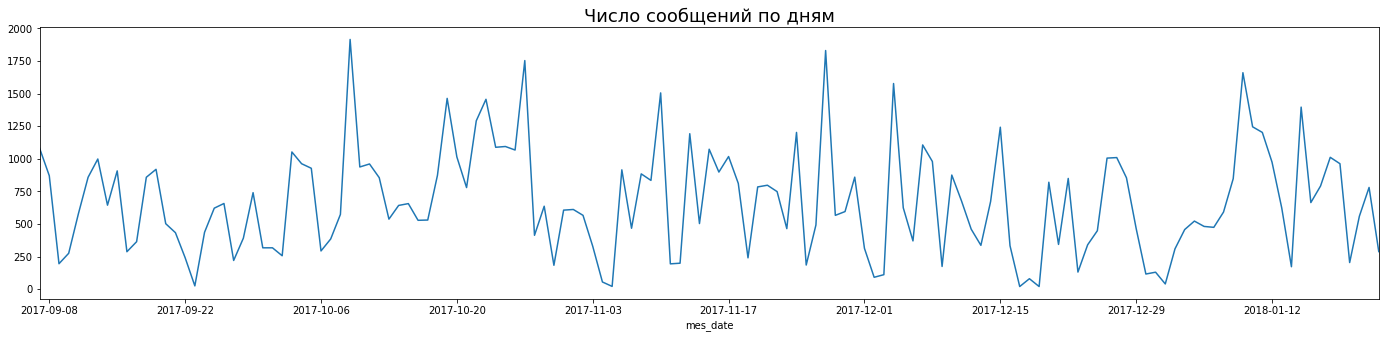

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по дням', fontsize=18)

### И по времени: как видим максимум неплохо коррелирует с рабочим днем:)

Пришел на работу - открыл чатик. Все правильно сделал!

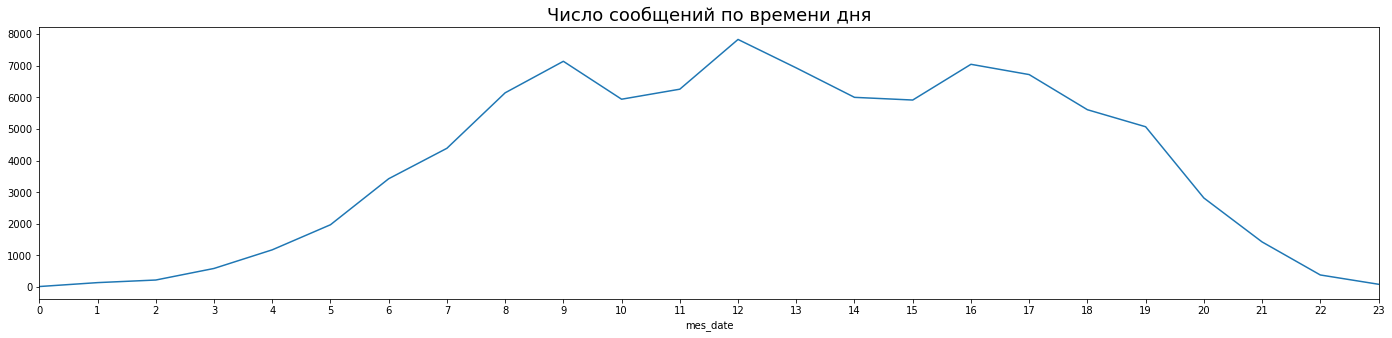

In [9]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по времени дня', fontsize=18)
plt.xticks(range(24))
plt.show()

### Тематическая модель по неделям

В общем-то всюду ниже трэш - можно не смотреть.

In [71]:
day_text = corpus.groupby(corpus.mes_date.apply(lambda x: x.week)).agg(lambda x: ' '.join(x))['text']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.05, max_df=0.999)
counts = vectorizer.fit_transform(day_text)
print(counts.shape)
print(Counter(' '.join(day_text.values).split()).most_common(10))

corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

(21, 28888)
[('просто', 3021), ('вообще', 1773), ('тебе', 1525), ('норм', 1152), ('кстати', 1092), ('1', 899), ('вроде', 896), ('почему', 839), ('хотя', 833), ('такое', 824)]


In [72]:
import gensim

gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
print([corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-20:][::-1]])
print([corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])

['типа', 'пхп', 'общем', 'зп', 'именно', 'стоит', 'жить', 'этим', 'проблема', 'скала', 'возможно', 'самое', 'кому', 'достаточно', 'согласен', 'дальше', 'везде', 'плохо', 'типо', 'кода']
['производные', 'показывай', 'показыать', 'показательная', 'показатели', 'договоры', 'показателей', 'догонишь', 'догоняет', 'додумал', 'додумались', 'показало', 'додумать', 'додумывать', 'доебали', 'покажь', 'показываться', 'показываются', 'договариваться', 'покатушках']


In [73]:
num_topics = 5  # число тем в модели LDA
alpha = [0.1] * num_topics
current_iter = 50  # число итераций вариационного вывода
current_passes = 50  # число проходов по датасету
alpha_value = 0.1

score_dict = {}
time_dict = {}
t_start = time()
lda = gensim.models.LdaModel(
    corpus=gensim_corpus,
    passes=current_passes,
    num_topics=num_topics,
    alpha=[alpha_value] * num_topics,
    iterations=current_iter,
    id2word=corpus_id2word,
    eval_every=0,
    random_state=1204
)
current_score = lda.bound(gensim_corpus)
score_dict[alpha_value] = current_score
time_ellapsed = int(time() - t_start)
time_dict[alpha_value] = time_ellapsed
print('ELBO = {1:.4f}, time: {2} seconds'.format(
    alpha_value, current_score, time_ellapsed))

ELBO = -2493964.2741, time: 94 seconds


In [74]:
gamma, _ = lda.inference(gensim_corpus)
gamma = gamma / gamma.sum(1).reshape(-1, 1)
gamma.shape

(21, 5)

In [75]:
for topic_index in range(lda.num_topics):
    print('{} topic:'.format(topic_index), ', '.join(list(zip(*lda.show_topic(topic_index, topn=15)))[0]))

0 topic: пхп, типа, общем, руби, именно, стоит, скала, зп, проблема, си, этим, достаточно, jvm, стрим, кода
1 topic: типа, жить, именно, стоит, зп, общем, возможно, кому, пхп, пидор, самое, момент, смысл, хочет, этим
2 topic: пхп, зп, этим, типа, жить, общем, стоит, именно, самое, scala, проблема, скала, принципе, смысл, делает
3 topic: типа, общем, пхп, стоит, именно, зп, жить, фп, этим, вариант, 20, принципе, дальше, проблема, назад
4 topic: зп, типа, общем, этим, религия, именно, религии, пхп, жить, пример, плохо, факт, проблема, типо, суть


In [78]:
for topic_index in range(5):
    print('Topic {0}'.format(topic_index))
    best_doc_indexes = gamma[:, topic_index].argsort()[-5:][::-1]
    for doc in best_doc_indexes:
        print('Topic probability: {0:.1%}, {1}'.format(gamma[doc, topic_index], day_text.index[doc]))
    print()

Topic 0
Topic probability: 100.0%, 45
Topic probability: 100.0%, 40
Topic probability: 100.0%, 37
Topic probability: 100.0%, 39
Topic probability: 100.0%, 36

Topic 1
Topic probability: 100.0%, 2
Topic probability: 100.0%, 47
Topic probability: 100.0%, 3
Topic probability: 100.0%, 52
Topic probability: 100.0%, 44

Topic 2
Topic probability: 0.0%, 4
Topic probability: 0.0%, 36
Topic probability: 0.0%, 44
Topic probability: 0.0%, 1
Topic probability: 0.0%, 51

Topic 3
Topic probability: 100.0%, 43
Topic probability: 100.0%, 48
Topic probability: 99.8%, 1
Topic probability: 99.6%, 38
Topic probability: 0.0%, 4

Topic 4
Topic probability: 100.0%, 49
Topic probability: 100.0%, 50
Topic probability: 100.0%, 42
Topic probability: 0.0%, 41
Topic probability: 0.0%, 4



### Тематическая модель по пользователям

In [169]:
users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.1, max_df=0.35)
counts = vectorizer.fit_transform(users_text)
print(counts.shape)
print(Counter(' '.join(day_text.values).split()).most_common(10))

corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

(67, 4814)
[('просто', 3021), ('вообще', 1773), ('тебе', 1525), ('норм', 1152), ('кстати', 1092), ('1', 899), ('вроде', 896), ('почему', 839), ('хотя', 833), ('такое', 824)]


In [170]:
import gensim

gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
print([corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-20:][::-1]])
print([corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])

['чет', 'угу', 'жи', 'хуй', 'скала', 'нихуя', 'блять', 'пыхе', 'изи', 'похуй', 'go', 'пыхер', 'походу', 'причем', 'видимо', 'юзать', 'суть', 'жаба', 'scala', 'си']
['кидаю', 'лечение', 'производства', 'необходимость', 'психология', 'красавчик', 'низкая', 'войне', 'концерт', 'фишки', 'оборудование', 'константы', 'гофер', 'комментарии', 'computer', 'рассказывают', 'удаляют', 'применение', 'нейросети', 'борьба']


In [171]:
from tqdm import tqdm_notebook

num_topics = 10  # число тем в модели LDA
alpha = [0.1] * num_topics
current_iter = 20  # число итераций вариационного вывода
current_passes = 50  # число проходов по датасету
alpha_value = 0.1

score_dict = {}
time_dict = {}
t_start = time()
lda = gensim.models.LdaModel(
    corpus=gensim_corpus,
    passes=current_passes,
    num_topics=num_topics,
    alpha=[alpha_value] * num_topics,
    iterations=current_iter,
    id2word=corpus_id2word,
    eval_every=0,
    random_state=1204
)
current_score = lda.bound(gensim_corpus)
score_dict[alpha_value] = current_score
time_ellapsed = int(time() - t_start)
time_dict[alpha_value] = time_ellapsed
print('ELBO = {1:.4f}, time: {2} seconds'.format(
    alpha_value, current_score, time_ellapsed))

ELBO = -1107807.2382, time: 30 seconds


In [172]:
gamma, _ = lda.inference(gensim_corpus)
gamma = gamma / gamma.sum(1).reshape(-1, 1)
gamma.shape

(67, 10)

In [173]:
for topic_index in range(lda.num_topics):
    print('{} topic:'.format(topic_index), ', '.join(list(zip(*lda.show_topic(topic_index, topn=15)))[0]))

0 topic: чё, пыхер, блэт, айрат, збс, блять, пидор, прост, ппц, пыхеры, жава, чтоли, чел, хуй, толик
1 topic: ит, дотнет, net, угу, 000, microsoft, server, шарп, visual, джава, laravel, тян, нить, windows, номер
2 topic: походу, чет, видимо, идее, си, насчет, жаве, бабки, яп, имхо, религии, религия, ааа, тд, толик
3 topic: угу, чет, жи, блять, изи, нихуя, scala, причем, разрезе, go, жаба, порой, скала, хуй, суть
4 topic: гавно, чет, гоу, апи, пздц, счет, хуй, изза, докер, каспи, похуй, ваще, примеру, вью, тесты
5 topic: false, ребят, next, pro, окей, else, разрабы, слушай, жесть, маке, наверно, джависты, дай, хату, vue
6 topic: хуй, збс, найду, увидел, бот, попробовать, собрать, еду, зайти, жрет, помимо, узнать, пк, ставишь, чувство
7 topic: требования, git, знание, обязанности, труда, оплата, понимание, задач, банки, бэкэнд, ооп, лишь, написано, каких, дней
8 topic: пыхе, нихуя, пыхер, похуй, блядь, сука, шо, пыха, пыху, пыхи, пыхеров, юзать, иди, жаба, хуй
9 topic: скала, использоват

In [174]:
for topic_index in range(num_topics):
    print('Topic {0}'.format(topic_index))
    best_doc_indexes = gamma[:, topic_index].argsort()[-5:][::-1]
    for doc in best_doc_indexes:
        print('Topic probability: {0:.1%}, {1}'.format(gamma[doc, topic_index], users_text.index[doc]))
    print()

Topic 0
Topic probability: 99.8%, _Tavke(tavke)
Topic probability: 81.4%, Zh_Airat(codev0)
Topic probability: 77.2%, _resurtm(resurtm)
Topic probability: 58.3%, _Azamat :3(alliwantitsyou)
Topic probability: 54.3%, A_Ержан(Astdev)

Topic 1
Topic probability: 99.9%, Raimbayev_Iskander(IskanderRaimbayev)
Topic probability: 99.8%, Ai_Askar(AskarAi)
Topic probability: 99.6%, _rsska(rsska)
Topic probability: 98.9%, Yasnopolski_Felix(FelixTheMagnificent)
Topic probability: 14.7%, Meleshko_Dmitriy(mitrio)

Topic 2
Topic probability: 98.3%, Wick_John(Kazakh_man)
Topic probability: 86.0%, _SSH()
Topic probability: 83.4%, Сабыргалиев_Таир(tairs)
Topic probability: 82.5%, _Leo(leotrubach)
Topic probability: 70.7%, Зет_Гражданин()

Topic 3
Topic probability: 93.9%, _Alexandr(shadowsmind)
Topic probability: 60.1%, Noskova_Yana()
Topic probability: 33.4%, Hinex_Roman(hinex)
Topic probability: 26.6%, Viktorson_Dmitriy(pengovan)
Topic probability: 24.6%, _Bakhtiyar(jdbaha)

Topic 4
Topic probability: 7

In [175]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]
    
import pyLDAvis.gensim

my_full_corpus = MyScipy2Corpus(counts)
my_dictionary = MyDictionary(vectorizer.vocabulary_)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

/home/sneddy/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
